# VAE reconstruct

In [1]:
import os
import io
import cv2
import copy
import math
import random
import numpy as np
import pickle as pkl
import datetime
from collections import deque
from tqdm import tqdm, trange
from typing import Deque, Dict, List, Tuple

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split


## hyper parameters

In [2]:
parameters = dict(
    kernel=3,
    stride=2,
    padding=2,
    latent=128,
    deconv_dim=32,
    deconv_channel=128,
    adjust_linear=235,
    epoch=100,
    learning_rate=0.001,
    batch_size=128,
    lambda_kld=1e-5,
    decoder="deconv",
)

class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)
config = Struct(**parameters)

## download & prepare dataset

In [ ]:
# !gdown --id 1w-o0896Biga-DrSG0gZKq9z4y5bFWuW8
# !unzip -o -q pkl-transitions-20210704T103021Z-001.zip

Downloading...
From: https://drive.google.com/uc?id=1w-o0896Biga-DrSG0gZKq9z4y5bFWuW8
To: /content/pkl-transitions-20210704T103021Z-001.zip
108MB [00:01, 85.2MB/s]


In [3]:
# for dataset
paths = []
main_path = '../pkl-transitions'
dirs = os.listdir(main_path)
dirs.sort()
for d in dirs:
    dirs1 = os.listdir(main_path+'/'+d)
    dirs1.sort()
    for d2 in dirs1:
        paths.append(main_path+'/'+d+'/'+d2)
print('%d files' % len(paths))

228 files


In [4]:
class MMDataset(Dataset):
    def __init__(self, paths):
        self.transitions = []

        for p in tqdm(paths):
            with open(p, "rb") as f:
                demo = pkl.load(f, encoding="bytes")
                self.transitions.extend(demo)

    def __getitem__(self, index):
        mm_scan = self.transitions[index][b'mm_scan']
        laser_scan = self.transitions[index][b'laser_scan']
        mm_scan = torch.Tensor(mm_scan).reshape(1, -1)
        laser_scan = torch.Tensor(laser_scan).reshape(1, -1)

        return mm_scan, laser_scan

    def __len__(self):
        return len(self.transitions)
mm_dataset = MMDataset(paths)

loader = DataLoader(dataset=mm_dataset,
                    batch_size=config.batch_size,
                    shuffle=True,
                    num_workers=2)

100%|██████████| 228/228 [00:02<00:00, 79.85it/s]


## Model

In [5]:
class MMvae(nn.Module):
    def __init__(self):
        super(MMvae, self).__init__()
        kernel = 3
        stride = 2
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=kernel, stride=stride),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=kernel, stride=stride),
            nn.ReLU()
        )

        dim = 64*59
        self.linear1 = nn.Sequential(
            nn.Linear(dim, 512),
            nn.ReLU()
        )
        self.en_fc1 = nn.Linear(512, config.latent)
        self.en_fc2 = nn.Linear(512, config.latent)

        self.de_fc1 = nn.Sequential(
            nn.Linear(config.latent, config.deconv_channel*config.deconv_dim),
            nn.ReLU()
        )

        self.de_conv = nn.Sequential(
            nn.ConvTranspose1d(config.deconv_channel, config.deconv_channel //
                               2, kernel, stride=stride, padding=config.padding),
            # nn.ReLU(),
            nn.ConvTranspose1d(config.deconv_channel//2, config.deconv_channel //
                               4, kernel, stride=stride, padding=config.padding),
            # nn.ReLU(),
            nn.ConvTranspose1d(config.deconv_channel//4, 1,
                               kernel, stride=stride, padding=config.padding),
            # nn.ReLU(),
        )
        self.adjust_linear = nn.Sequential(
            nn.Linear(config.adjust_linear, 241),
            nn.ReLU()
        )

    def encoder(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        mean = self.en_fc1(x)
        logvar = self.en_fc2(x)
        return mean, logvar

    def reparameter(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mean + eps*std

    def decoder(self, x):
        x = self.de_fc1(x)
        x = x.view(-1, config.deconv_channel, config.deconv_dim)
        x = self.de_conv(x)
        x = self.adjust_linear(x)
        return x

    def forward(self, x):
        mean, logvar = self.encoder(x)
        x = self.reparameter(mean, logvar)
        x = self.decoder(x)
        return x, mean, logvar


## train VAE

### config

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device, ', device)
model = MMvae()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

device,  cuda:0


### start

In [7]:
recon_loss = nn.MSELoss()

def loss_function(x, x_hat, mean, logvar):
    # recon = F.binary_cross_entropy(x_hat, x, reduction='sum')
    recon = recon_loss(x_hat, x)

    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    return recon + config.lambda_kld*KLD, recon, KLD

In [8]:
metrics = {'total loss': [],'reconstruction loss': [], 'KL-divergence': []}
step = 0
t = trange(config.epoch)
for e in t:
    for mm_scan, laser_scan in loader:
        mm_scan = mm_scan.to(device)
        laser_scan = laser_scan.to(device)

        optimizer.zero_grad()
        x_hat, mean, logvar = model(mm_scan)
        elbo, recon, kld = loss_function(laser_scan, x_hat, mean, logvar)
        elbo.backward()
        optimizer.step()

        metrics['total loss'].append(elbo.item())
        metrics['reconstruction loss'].append(recon.item())
        metrics['KL-divergence'].append(kld.item())

        t.set_description("step %d"%step)
        step+=1



step 1138:   1%|          | 1/100 [00:14<24:18, 14.73s/it]


KeyboardInterrupt: 

In [9]:
# Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

torch.save(model.state_dict(), '../model/vae/first_VAE.pth')

### logs

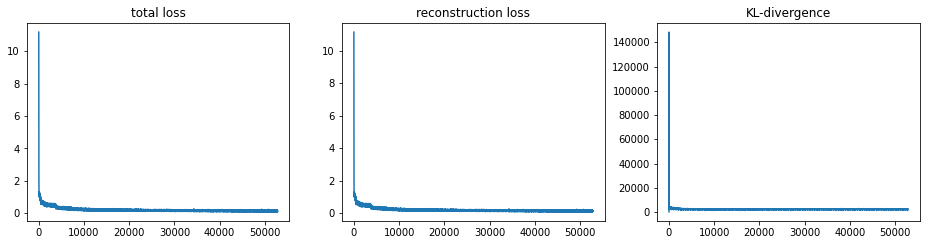

In [10]:
fig = plt.figure(figsize=(16,8))
indx = 1
for k, v in metrics.items():
  ax = plt.subplot(2,3,indx)
  plt.title(k)
  plt.plot(np.arange(len(v)), v)
  indx+=1

## load pretrained model (optional)

In [ ]:
# !gdown --id 1dUS9pnwGn9oUI9PIVqzGpGL3M7aXVquD

Downloading...
From: https://drive.google.com/uc?id=1dUS9pnwGn9oUI9PIVqzGpGL3M7aXVquD
To: /content/0726_1557.pth
10.8MB [00:00, 26.0MB/s]


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device, ', device)
model = MMvae()
model.to(device)

model.load_state_dict(torch.load("/home/lunfee/PycharmProjects/radar-transformer/model/vae/first_VAE.pth"))
model.eval()


device,  cuda:0


MMvae(
  (conv): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(2,))
    (1): ReLU()
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(2,))
    (3): ReLU()
  )
  (linear1): Sequential(
    (0): Linear(in_features=3776, out_features=512, bias=True)
    (1): ReLU()
  )
  (en_fc1): Linear(in_features=512, out_features=128, bias=True)
  (en_fc2): Linear(in_features=512, out_features=128, bias=True)
  (de_fc1): Sequential(
    (0): Linear(in_features=128, out_features=4096, bias=True)
    (1): ReLU()
  )
  (de_conv): Sequential(
    (0): ConvTranspose1d(128, 64, kernel_size=(3,), stride=(2,), padding=(2,))
    (1): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(2,), padding=(2,))
    (2): ConvTranspose1d(32, 1, kernel_size=(3,), stride=(2,), padding=(2,))
  )
  (adjust_linear): Sequential(
    (0): Linear(in_features=235, out_features=241, bias=True)
    (1): ReLU()
  )
)

## evaluation

In [12]:
name_corridor = [
'0717_1411','0720_1129','0722_1428','0722_1437','0722_1448','0722_1500',
'0722_1506','0722_1510','0722_1514','0724_1101','0724_1132','0724_1204',
'0727_1005','0727_1027','0727_1102','0727_1435','0727_1452','0727_1510',
'0727_1520','0805_1108','0805_1127','0805_1147']

name_parking = ['0717_1504','0720_1105','0805_1349','0805_1425']

paths_corridor, paths_parking = [], []
main_path = '/content/pkl-transitions'
dirs = os.listdir(main_path)
dirs.sort()
for d in dirs:
    dirs1 = os.listdir(main_path+'/'+d)
    dirs1.sort()
    for d2 in dirs1:
        if any(s in d2 for s in name_corridor):
            paths_corridor.append(main_path+'/'+d+'/'+d2)
        elif any(s in d2 for s in name_parking):
            paths_parking.append(main_path+'/'+d+'/'+d2)
print('corridor files %d'%len(paths_corridor))
print('parking files %d'%len(paths_parking))

FileNotFoundError: [Errno 2] No such file or directory: '/content/pkl-transitions'

In [ ]:
batch_size = 128
model.eval()

corridor_dataset = MMDataset(paths_corridor)
loader_corridor = DataLoader(dataset=corridor_dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=2)

parking_dataset = MMDataset(paths_parking)
loader_parking = DataLoader(dataset=parking_dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=2)

100%|██████████| 31/31 [00:00<00:00, 66.72it/s]


In [ ]:
l1 = nn.L1Loss()

L1 = []
for mm_scan, laser_scan in loader_corridor:
    mm_scan = mm_scan.to(device)
    
    x_hat,_,_ = model(mm_scan)
    x_hat = x_hat.detach().cpu()
    
    L1.append(l1(laser_scan,x_hat))
    
print("\n corridor L1: %.4f"%np.mean(L1))


 corridor L1: 0.2315


In [ ]:
L1 = []
for mm_scan, laser_scan in loader_parking:
    mm_scan = mm_scan.to(device)
    
    x_hat,_,_ = model(mm_scan)
    x_hat = x_hat.detach().cpu()
    
    L1.append(l1(laser_scan,x_hat))

    
print("\n parking L1: %.4f"%np.mean(L1))


 parking L1: 0.2722


## visualize

In [13]:
def laser_visual(lasers=[], names=[], range_limit=6):
  fig = plt.figure(figsize=(8, 8))
  colors=['#3483EB','#FFA500','#15B01D']
  for i, l in enumerate(lasers):
    angle = 120
    xp = []
    yp = []
    for r in l:
        if r <= range_limit:
            yp.append(r * math.cos(math.radians(angle)))
            xp.append(r * math.sin(math.radians(angle)))
        angle -= 1
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.plot(xp, yp, '.', color=colors[i], label=names[i])
  plt.legend(loc='lower right', fontsize=15)

### reconstruct sample
repeate this block to visualize different samples

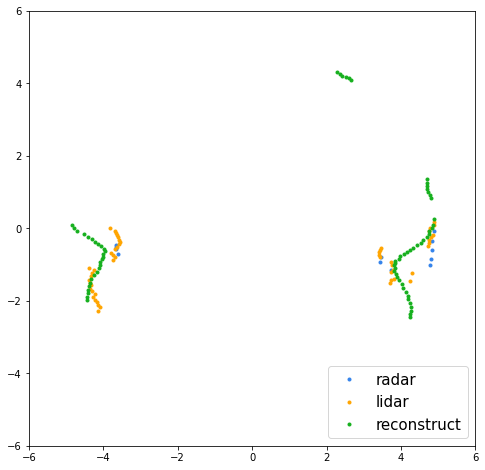

In [14]:
sample_loader=loader
# sample_loader=loader_corridor
# sample_loader=loader_parking

mm_scan, laser_scan = next(iter(sample_loader))
x = mm_scan.to(device)
reconstruct,_,_ = model(x)
reconstruct = reconstruct[0][0].detach().cpu().numpy()
mm_scan=mm_scan[0][0].numpy()
laser_scan=laser_scan[0][0].numpy()

laser_visual([mm_scan, laser_scan, reconstruct], names=['radar', 'lidar', 'reconstruct'], range_limit=4.9)

In [7]:
with open(r'/home/lunfee/PycharmProjects/radar-transformer/data/pkl/dataset_0720_1120.pkl', 'rb') as mm:
    data1 = pkl.load(mm, encoding='bytes')
